In [1]:
from os import listdir
from os.path import isfile, join
from os import system
import pandas as pd
import numpy as np
from glob import glob
from geopy.geocoders import Nominatim
import gzip
import librosa

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO
    
import matplotlib.pyplot as plt

#import gmplot
import folium

# make figures easier to annotate
import mplcursors

import geopy
import plotly.graph_objects as go

import librosa.display
import librosa

from IPython.display import Audio

# Loading

In [3]:
person2_UUID = "1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842"

feature_labels = "/Users/yzhao/Documents/Data/Assignment2_data/ExtraSensory.per_uuid_features_labels/"

In [4]:
p2_labels = pd.read_csv(feature_labels + person2_UUID+".features_labels."+ "csv.gz", compression='gzip')

# Lab 04/12's topic:
- How to add traces to maps 
- How to perform geocoding and get address 
- How to calculate distances between 2 points on a sphere 
- Realistic understanding of distance traveled

In [5]:
location_dir = "/Users/yzhao/Documents/Data/Assignment2_data/ExtraSensory.per_uuid_absolute_location/"
locations = pd.read_csv(location_dir + person2_UUID +".absolute_locations."+ "csv.gz", compression='gzip')

### Plotting to have an intuitive understanding

Text(0.5, 1.0, 'GPS traces')

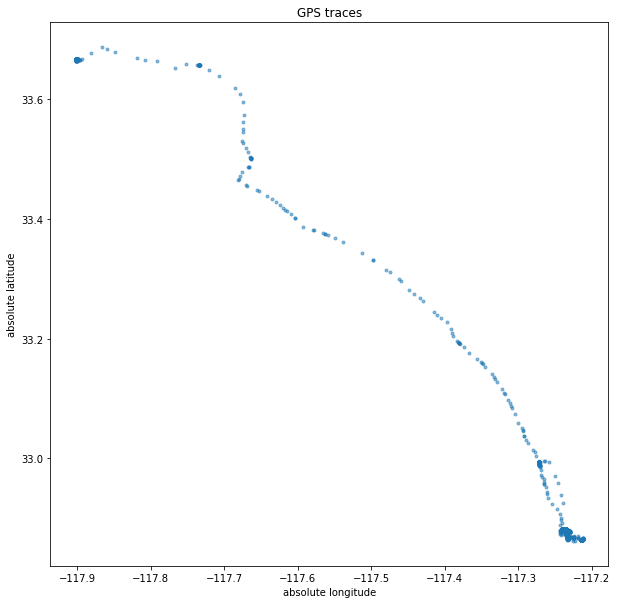

In [7]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.scatter(locations.longitude, locations.latitude, marker = '.', alpha = 0.5)

plt.xlabel("absolute longitude")
plt.ylabel("absolute latitude")
plt.title("GPS traces")

## Overlay coordinates to map using folium

In [8]:
min_lat, max_lat, min_lon, max_lon = \
min(locations.latitude), max(locations.latitude), \
min(locations.longitude), max(locations.longitude)

avg_lat, avg_lon = np.mean(locations.latitude), np.mean(locations.longitude)

In [ ]:
# Load map centred on average coordinates
map_ = folium.Map(location=[avg_lat, avg_lon], tiles="cartodbpositron",
                  zoom_start=11)
points = []

#add markers
for index, row in locations.iterrows(): 
    if row.isna().sum() == 0:
        points.append(tuple([row['latitude'], row['longitude']]))
        
        #plot geolocation as points on map
        #folium.Marker([row['latitude'], row['longitude']]).add_to(my_map)
 
#plot geolocation as lines
folium.PolyLine(points, color="blue", weight=2.5, opacity=1).add_to(my_map)
 
# Save map
my_map.save("./person2_overlayed_map.html")

## Static activities
### Activity heatmap

In [9]:
sleeping_mask = p2_labels["label:SLEEPING"]==1
computer_mask = p2_labels['label:COMPUTER_WORK']==1
talking_mask = p2_labels['label:TALKING']==1
eating_mask = p2_labels['label:EATING']==1
walking_mask = p2_labels['label:FIX_walking']==1
driving_mask = p2_labels['label:IN_A_CAR']==1


In [10]:
my_map_static = folium.Map(location=[avg_lat, avg_lon], zoom_start=16)
sleeping_points = []
eating_points = []
eating_df = pd.DataFrame()
sleeping_df = pd.DataFrame()

first = True
for index, row in locations[sleeping_mask].iterrows(): 
    if row.isna().sum() == 0:
        #print(row)
        df_tmp = pd.DataFrame(({'latitude': [row['latitude']], 'longitude': [row['longitude']], }))
        sleeping_df=pd.concat([sleeping_df, df_tmp], ignore_index = True, axis = 0)


for index, row in locations[eating_mask].iterrows(): 
    if row.isna().sum() == 0:
        df_tmp = pd.DataFrame(({'latitude': [row['latitude']], 'longitude': [row['longitude']], }))
        eating_df=pd.concat([eating_df, df_tmp], ignore_index = True, axis = 0)


In [ ]:
avg_lon

In [11]:
#import pandas as pd
#quakes = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')

#import plotly.graph_objects as go
fig = go.Figure(go.Densitymapbox(lat=sleeping_df.latitude, lon=sleeping_df.longitude,
                                 radius=5))
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=avg_lon)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title = "Eating ")
fig.show()

In [12]:
fig = go.Figure(go.Densitymapbox(lat=eating_df.latitude, lon=eating_df.longitude,
                                 radius=5))
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=avg_lon)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, title = "Eating ")
fig.show()

### Geocoding: Get address

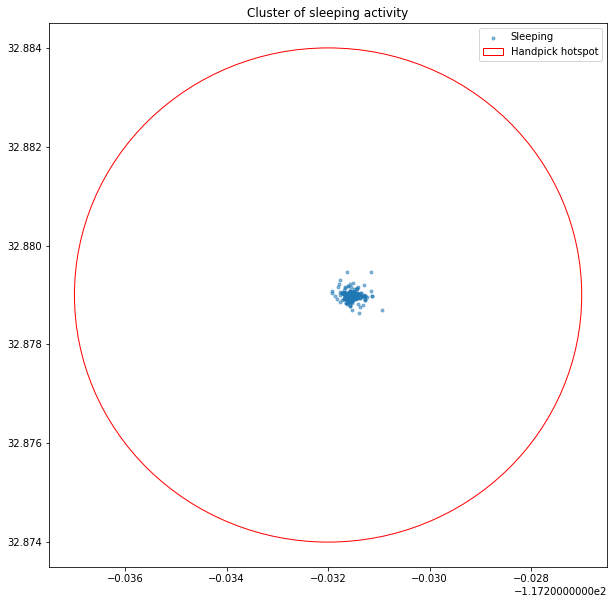

In [16]:
#plt.scatter(locations.longitude[eating_mask], locations.latitude[eating_mask], marker = '.', alpha = 0.5)
plt.scatter(locations.longitude[sleeping_mask], locations.latitude[sleeping_mask], marker = '.', alpha = 0.5)
plt.gca().add_patch(Circle((-117.232, 32.879), 0.005, color = "red", fill=False))

plt.legend(["Sleeping", "Handpick hotspot", ])
plt.title('Cluster of sleeping activity')
plt.show()

### Mapping hotspot to geolocation

**Geopy is open-source while most geocoder are paid. Please be gentle on their server and limit to 1s per query**

In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="http")
sleeping_centroid = geolocator.reverse(str(32.879) + "," + str(-117.232))

In [18]:
sleeping_centroid

Location(University of California, San Diego, 9500, Gilman Drive, University City, San Diego, San Diego County, California, 92093, United States, (32.879380299999994, -117.23110878080598, 0.0))

### Clusters

In [19]:
# for clustering analysis 
from sklearn import preprocessing, cluster
import scipy.cluster

In [20]:
locations.fillna(method = "bfill")

timestamp   latitude   longitude
0     1440627472  32.882277 -117.234632
1     1440627533  32.882289 -117.234622
2     1440627593  32.882289 -117.234629
3     1440627654  32.882292 -117.234630
4     1440627712  32.882284 -117.234628
...          ...        ...         ...
7370  1441292839  32.878956 -117.231589
7371  1441292931  32.878955 -117.231589
7372  1441292959  32.878956 -117.231589
7373  1441293052  32.878956 -117.231589
7374  1441293083  32.878956 -117.231589

[7375 rows x 3 columns]

In [21]:
X = locations[["latitude","longitude"]]
X = X.dropna()

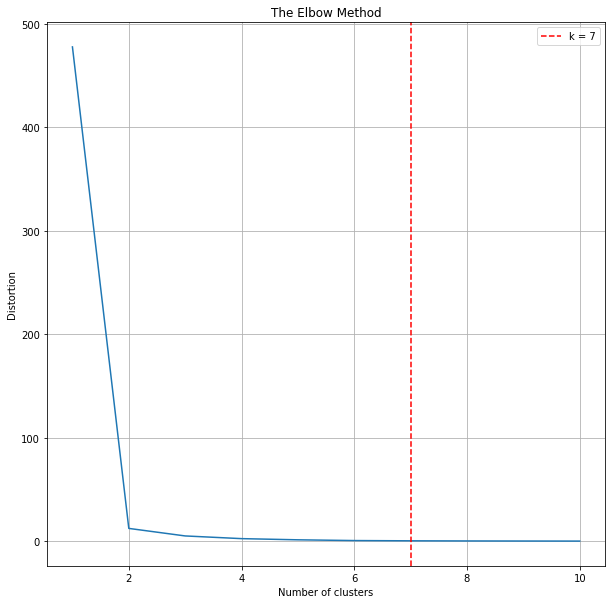

In [23]:
max_k = 10

## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
    
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))

## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

In [24]:
k = 7
model = cluster.KMeans(n_clusters=k, init='k-means++')

## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

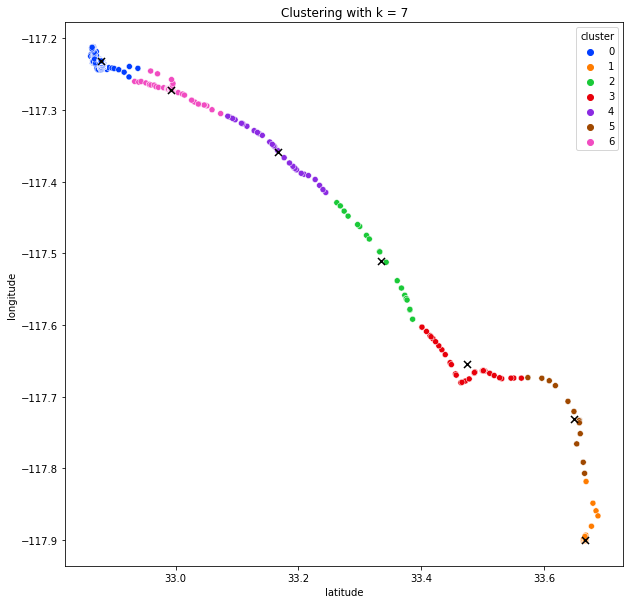

In [25]:
## plot
import seaborn as sns

fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=dtf_X, 
                palette=sns.color_palette("bright",k),
                hue='cluster',
                legend="brief", ax=ax).set_title('Clustering with k = 7')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

## Movements

In [26]:
my_map_activity = folium.Map(location=[avg_lat, avg_lon], zoom_start=16)
driving_points = []

        
for index, row in locations[driving_mask].iterrows(): 
    if row.isna().sum() == 0:
        driving_points.append(tuple([row['latitude'], row['longitude']]))
        
# plot geolocation as lines
folium.PolyLine(driving_points, color="blue", weight=3, opacity=0.7).add_to(my_map_activity)


# Save map
my_map_activity.save("./A3_lab_driving_p2.html")

In [28]:
my_map_activity = folium.Map(location=[avg_lat, avg_lon], zoom_start=16)
walking_points = []

for index, row in locations[walking_mask].iterrows(): 
    if row.isna().sum() == 0:
        walking_points.append(tuple([row['latitude'], row['longitude']]))

folium.PolyLine(walking_points, color="blue", weight=3, opacity=0.7).add_to(my_map_activity)

# Save map
my_map_activity.save("./A3_lab_walking_p2.html")

### Calculate distance

![title](https://miro.medium.com/max/1126/1*Lk190DN2RqwcmX3Vkju7KQ.png)

![title](https://images.squarespace-cdn.com/content/v1/57a9d8dcd482e9bbf179f445/1495447182958-LF11ND21AHG1L369SAKC/ke17ZwdGBToddI8pDm48kPHluhoemA45oqIiZDUH-XNZw-zPPgdn4jUwVcJE1ZvWEtT5uBSRWt4vQZAgTJucoTqqXjS3CfNDSuuf31e0tVEeZIVzf2LLDbhB6disxDwnSHN8ZCMaiYzM1bkFmz7Vxz-3CTWZQ124CTRPXn-dnvM/image-asset.png?format=750w)





In [35]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    
    return c * r

### Between-sample distance traveled

In [38]:
between_distances = [0]
for i in range(1, len(locations)):
    if locations.loc[i,:].isna().sum() == 0: 
        dist = haversine(locations.loc[i-1, "longitude"], locations.loc[i-1, "latitude"], locations.loc[i, "longitude"], locations.loc[i, "latitude"])
        between_distances.append(dist)
    else:
        between_distances.append(0)


Text(0.5, 0, 'timestamp')

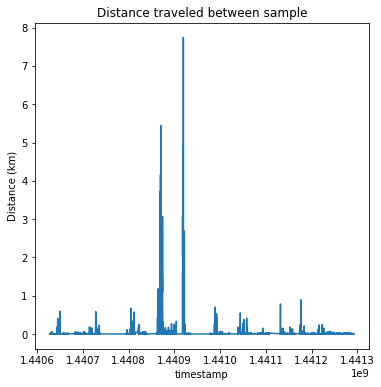

In [41]:
plt.rcParams["figure.figsize"] = (6, 6)

plt.plot(locations.timestamp, between_distances)
plt.title("Distance traveled between sample")
plt.ylabel("Distance (km)")
plt.xlabel("timestamp")

### Threaholding

You can do mathematical filtering:
- mean + 3 * std

Or you could do by inference: 
- A car drives maximum 80mph or 130 kmph, which is ~0.72 km per 20s. 
- Define your walking range 

# Make A3 Assignment

In [ ]:
p1_labels

## What kind of sitting: eating vs computer work?

In [ ]:
sitting_mask = p1_labels["label:SITTING"]==1 
eating_mask = p1_labels["label:EATING"]==1
computer_mask = p1_labels["label:COMPUTER_WORK"]==1
tv_mask = p1_labels["label:WATCHING_TV"]==1

In [ ]:
p1_labels[sitting_mask & eating_mask]

In [ ]:
sitting_mask = p2_labels["label:SITTING"]==1 
eating_mask = p2_labels["label:EATING"]==1  #425 samples
computer_mask = p2_labels["label:COMPUTER_WORK"]==1 #1622 samples 
driving_mask = p2_labels["label:IN_A_CAR"]==1

In [ ]:
p2_labels[sitting_mask & computer_mask]

In [ ]:
grooming_mask = p2_labels["label:GROOMING"]==1  #235
standing_mask = p2_labels["label:OR_standing"]==1 #980
p2_labels[standing_mask]

In [ ]:
p2_labels[driving_mask & sitting_mask] #36

internet_mask = p2_labels["label:SURFING_THE_INTERNET"]==1 	

In [ ]:
p2_labels[internet_mask & sitting_mask] #796

# Draft

### Visualize activity vs location 

In [ ]:
label_to_df = np.array(["N/A"] * len(activity_label))

In [ ]:
label_to_df[sitting_mask] = "Sitting"
label_to_df[running_mask] = "Running"
label_to_df[cycling_mask] = "Cycling"
label_to_df[standing_mask] = "Standing"
label_to_df[driving_mask] = "Driving"
label_to_df[walking_mask] = "Walking"

In [ ]:
locations['label'] = label_to_df

In [ ]:
#plt.scatter(locations_fillna.longitude[sitting_mask], locations_fillna.latitude[sitting_mask], marker = '*', alpha = 0.3)
#plt.scatter(locations_fillna.longitude[standing_mask], locations_fillna.latitude[standing_mask], marker = '*', alpha = 0.3)

plt.scatter(locations.longitude[running_mask], locations.latitude[running_mask], marker = '*', alpha = 0.3)
plt.scatter(locations.longitude[driving_mask], locations.latitude[driving_mask], marker = '*', alpha = 0.3)
plt.scatter(locations.longitude[cycling_mask], locations.latitude[cycling_mask], marker = '*', alpha = 0.1)
plt.scatter(locations.longitude[walking_mask], locations.latitude[walking_mask], marker = '*', alpha = 0.1)

plt.legend(["running", "driving", "cycling", "walking"])
fig, ax = plt.subplots()plt.title("Traces of moving activities")

In [ ]:
#fig, ax = plt.subplots()
from matplotlib.patches import Circle

plt.scatter(locations.longitude[standing_mask], locations.latitude[standing_mask], marker = '.', alpha = 0.5)
plt.scatter(locations.longitude[sitting_mask], locations.latitude[sitting_mask], marker = '.', alpha = 0.5)
#plt.gca().add_patch(Circle((-117.225, 32.87), 0.03, color = "red", fill=False))

plt.legend(["Eating", "Sleeping", ])
plt.title('Location of static activity')
plt.show()

### Identify hotspot for static activities

In [ ]:
# Add heatmap

### Less manual work: use clustering

In [ ]:
#statics = [locations.longitude[sitting_mask | standing_mask], locations.latitude[sitting_mask | standing_mask]]
statics = np.concatenate((locations.longitude[sitting_mask | standing_mask], locations.latitude[sitting_mask | standing_mask]), axis=0)
statics = statics.reshape(int(len(statics)/2), 2)
#statics = locations[['latitude', 'longitude']]
#statics = statics.loc[]

In [ ]:
statics.shape

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

clusters = AgglomerativeClustering(n_clusters = 3, linkage = 'ward', affinity = 'euclidean').fit(statics)
#clusters = SpectralClustering(n_clusters=3, affinity = "nearest_neighbors", assign_labels="discretize", random_state=0).fit(statics)

In [ ]:
for i in np.unique(clusters.labels_):
    plt.scatter(locations.longitude[sitting_mask | standing_mask][clusters.labels_ == i], locations.latitude[sitting_mask | standing_mask][clusters.labels_ == i], marker = 'o', alpha = 0.5)

plt.xlabel("absolute longitude")
plt.ylabel("absolute latitude")
plt.title("Clusters of static activity locations")
plt.legend(["cluster 0", "cluster 1", "cluster 2", "cluster 3"])

In [ ]:
clusters.labels_

## Relative Location

In [ ]:
walking_between_distances = [0]
driving_between_distances = [0]
running_between_distances = [0]
cycling_between_distances = [0]

for i in range(1, len(locations)):
    if locations.index.contains(i-1) & locations.index.contains(i):
        dist = haversine(locations.loc[i-1, "longitude"], locations.loc[i-1, "latitude"], locations.loc[i, "longitude"], locations.loc[i, "latitude"])
        
        #print (locations.loc[i-1, "label"])
        if (locations.loc[i-1, "label"] == "Wal"):
            walking_between_distances.append(dist)
        if (locations.loc[i-1, "label"] == "Dri"):
            driving_between_distances.append(dist)
        if (locations.loc[i-1, "label"] == "Run"):
            running_between_distances.append(dist)
        if (locations.loc[i-1, "label"] == "Cyc"):
            cycling_between_distances.append(dist)

In [ ]:
fig, axs = plt.subplots(2, 2, sharex = True, tight_layout=True)

axs[0, 0].hist(walking_between_distances, color = 'r')
axs[0, 0].set_xlabel = "km"
axs[0, 0].set_title = "Distribution of walking"

axs[0, 1].hist(running_between_distances, color = 'g')
axs[0, 1].set_xlabel = "km"
axs[0, 1].set_title = "Distribution of running"

axs[1, 0].hist(cycling_between_distances, color = 'b')
axs[1, 0].set_xlabel = "km"
axs[1, 0].set_title = "Distribution of cycling"

axs[1, 1].hist(driving_between_distances, color = 'magenta')
axs[1, 1].set_xlabel = "km"
axs[1, 1].set_title = "Distribution of driving"

plt.show()

**Let's take a look at driving**

In [ ]:
np.where(activity_label["original_label:DRIVE_-_I_M_THE_DRIVER"] == 1)[0]

In [ ]:
between_distances[6500] * 1000

In [ ]:
between_distances[2420] * 1000

### Thresholding

In [ ]:
## Trying some thresholds
between_distances = np.asarray(between_distances)
threshold = np.nanmean(between_distances) + 4*np.nanstd(between_distances)
#between_distances[between_distances > threshold] = 0

In [ ]:
upper_bound = np.nanmean(driving_between_distances) + 2*np.nanstd(driving_between_distances)

Or you could do by inference: 
- A car drives maximum 80mph or 130 kmph, which is ~0.72 km per 20s. 
- Define your walking range 

# Lab 04/12's topic: MFCC

## Talking

In [44]:
mfcc_dir = "/Users/yzhao/Documents/Data/Assignment2_data/person2-MFCC-1DBB0F6F-1F81-4A50-9DF4-CD62ACFA4842/"
talking_timestamp = str(1440880163)
talking = mfcc_dir + talking_timestamp + ".sound.mfcc"

In [45]:
target = p2_labels[p2_labels['timestamp'] == 1440880163]

In [46]:
p2_labels[p2_labels['timestamp'] == 1440880163]

timestamp  raw_acc:magnitude_stats:mean  raw_acc:magnitude_stats:std  \
2647  1440880163                      0.999038                     0.001645   

      raw_acc:magnitude_stats:moment3  raw_acc:magnitude_stats:moment4  \
2647                         0.001418                         0.002517   

      raw_acc:magnitude_stats:percentile25  \
2647                              0.998024   

      raw_acc:magnitude_stats:percentile50  \
2647                              0.998986   

      raw_acc:magnitude_stats:percentile75  \
2647                               0.99988   

      raw_acc:magnitude_stats:value_entropy  \
2647                               2.214598   

      raw_acc:magnitude_stats:time_entropy  ...  label:STAIRS_-_GOING_DOWN  \
2647                               6.68461  ...                        NaN   

      label:ELEVATOR  label:OR_standing  label:AT_SCHOOL  label:PHONE_IN_HAND  \
2647             NaN                0.0              0.0                  0.0   

      label:PHONE_IN_BAG  label:PHONE_ON_TABLE  label:WITH_CO-WORKERS  \
2647                 NaN                   0.0                    NaN   

      label:WITH_FRIENDS  label_source  
2647                 NaN             2  

[1 rows x 278 columns]

In [47]:
df = pd.read_csv(talking, sep=",", header=None, )

In [48]:
talking_mfcc = df.drop(columns=[13]).T.to_numpy()

In [49]:
talking_mfcc.shape

(13, 346)

In [50]:
#MFCC to mel

mel_talking = librosa.feature.inverse.mfcc_to_mel(talking_mfcc, n_mels=13)

In [187]:
# This reconstrut mfcc to audio. You don't need to do this. 
# talking_reconstruct = librosa.feature.inverse.mfcc_to_audio(talking_mfcc, 
#                                                             n_mels=13, 
#                                                             norm='ortho', n_fft = 4096, 
#                                                             sr = 22100, win_length = 2112, hop_length = 2112//2)

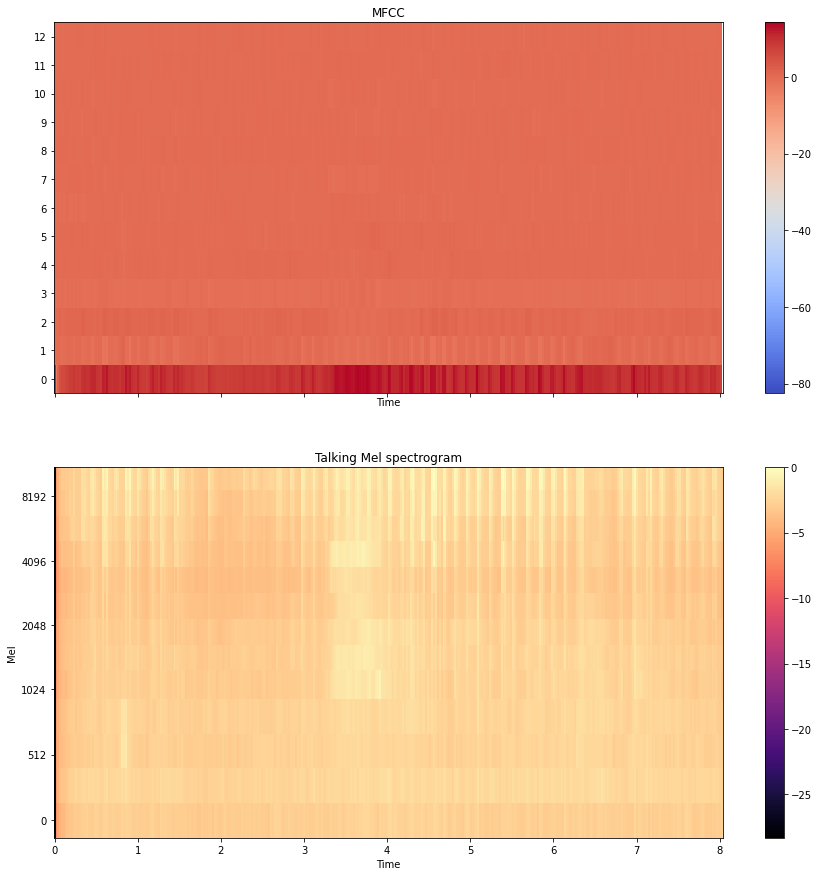

In [52]:
import librosa.display
plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(librosa.power_to_db(mel_talking, ref=np.max), sr = 22000, 
                               x_axis='time', y_axis='mel', fmax=10000,
                               ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='Talking Mel spectrogram')
ax[1].label_outer()
ax[1].set_ylabel('Mel')


img = librosa.display.specshow(talking_mfcc, x_axis='time', ax=ax[0])
fig.colorbar(img, ax=[ax[0]])
ax[0].set(title='MFCC')
ax[0].set_yticks(np.linspace(0, 12, 13))

## April 19th Demo: Audio to MFCC to Audio

In [70]:
human, sr = librosa.load(librosa.ex('libri1'))

In [71]:
Audio(data=human, rate=sr)

In [72]:
## Compute STFT 

D = librosa.stft(human) 
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

In [73]:
mfcc_ex = librosa.feature.mfcc(y = human, sr = sr, n_mfcc = 13)

In [74]:
mel_ex = librosa.feature.melspectrogram(y=human, sr=sr, n_fft=2048, hop_length=512)

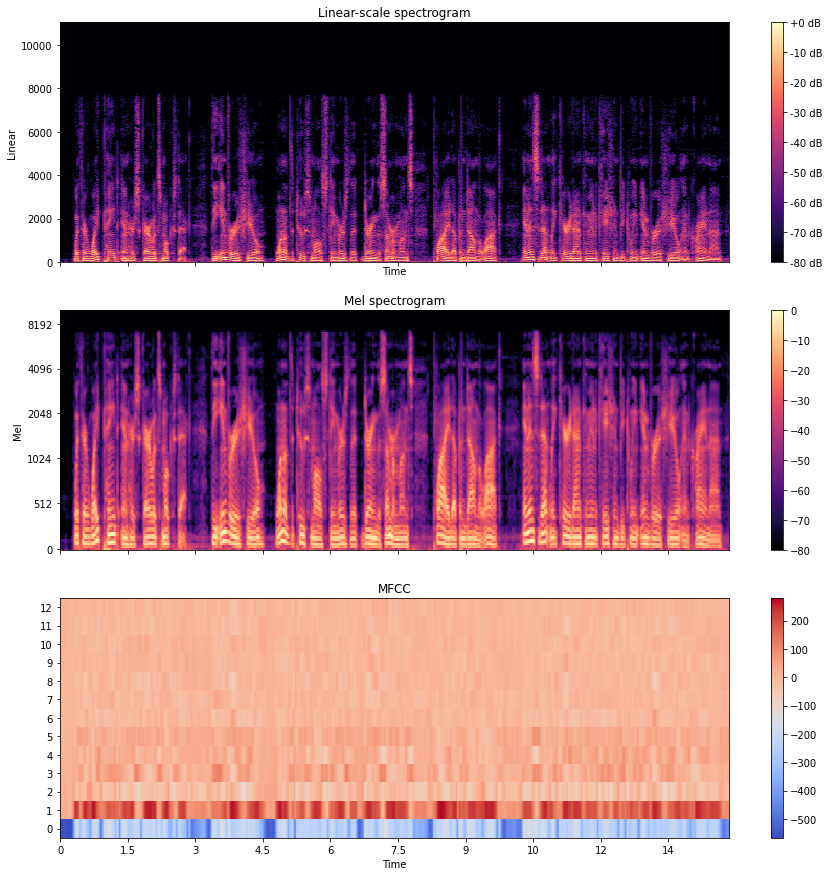

In [118]:
import librosa.display

plt.rcParams["figure.figsize"] = (15, 15)

fig, ax = plt.subplots(nrows=3, sharex=True)

img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax[0], fmax = 10000)
ax[0].set(title='Linear-scale spectrogram')
ax[0].set_ylabel('Linear')
fig.colorbar(img, ax=[ax[0]], format="%+2.f dB")


img = librosa.display.specshow(librosa.power_to_db(mel_ex, ref=np.max),
                               x_axis='time', y_axis='mel', fmax=10000,
                               ax=ax[1])
fig.colorbar(img, ax=[ax[1]])
ax[1].set(title='Mel spectrogram')
ax[1].label_outer()
ax[1].set_ylabel('Mel')


img = librosa.display.specshow(mfcc_ex, x_axis='time', ax=ax[2])
fig.colorbar(img, ax=[ax[2]])
ax[2].set(title='MFCC')
ax[2].set_yticks(np.linspace(0, 12, 13))

### Reconstruct to audio

In [197]:
mel = librosa.feature.inverse.mfcc_to_mel(mfcc_ex, n_mels=13)

In [203]:
audio = librosa.feature.inverse.mel_to_audio(mel, sr=sr, n_fft=2048, hop_length=512)

In [204]:
Audio(data=audio, rate=sr)

In [95]:
mfcc_ex.shape

(13, 640)

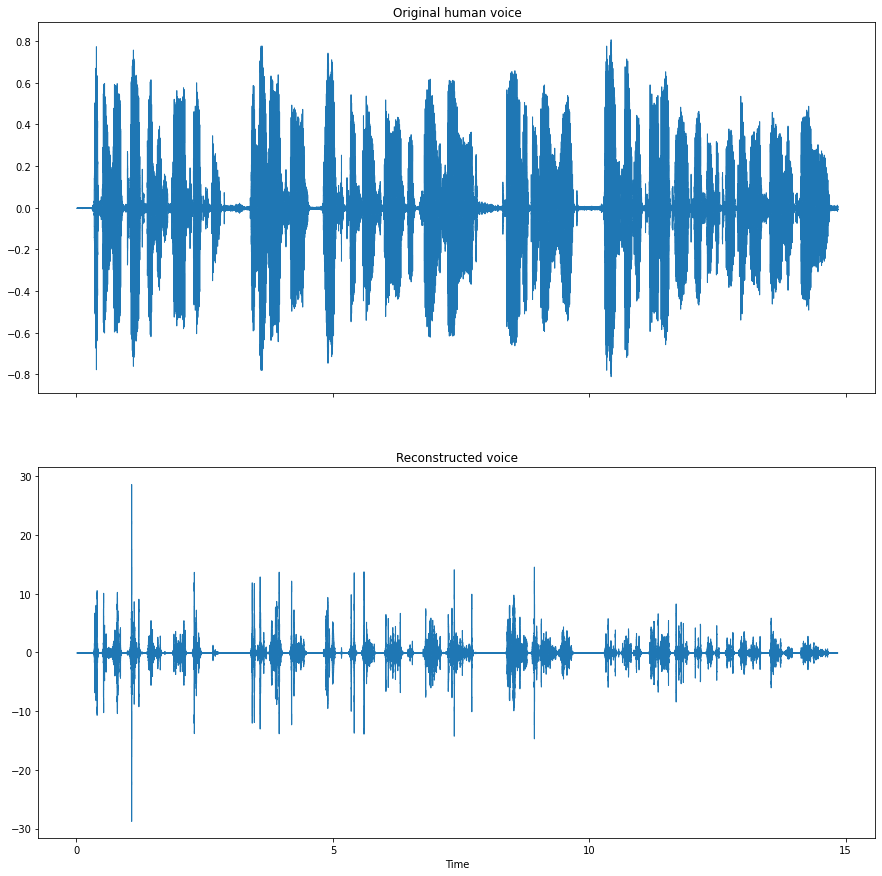

In [205]:
fig, ax = plt.subplots(nrows=2, sharex=True)
librosa.display.waveshow(human, sr=sr, ax=ax[0])
ax[0].set(title='Original human voice')
ax[0].label_outer()

librosa.display.waveshow(audio, sr=sr, ax=ax[1])
ax[1].set(title='Reconstructed voice')
ax[1].label_outer()